# Poker AI Setup

## Imports

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pokerenv.obs_indices as indices
from pokerenv.table import Table
from treys import Deck, Evaluator, Card
from pokerenv.common import GameState, PlayerState, PlayerAction, TablePosition, Action, action_list
from pokerenv.player import Player
from pokerenv.utils import pretty_print_hand, approx_gt, approx_lte
import types
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gym
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import huber_loss, cross_entropy
from collections import deque
from scipy import stats
from collections import Counter


## Create enviorment

In [157]:
class ModifiedTable(Table):
    def __init__(self, n_players, player_names=None, track_single_player=False, stack_low=50, stack_high=200, hand_history_location='hands/', invalid_action_penalty=0, SB=5, BB=10):
        super().__init__(n_players, player_names, track_single_player, stack_low, stack_high, hand_history_location, invalid_action_penalty)
        self.current_dealer = 0
        self.SB = SB
        self.BB = BB
        
    def reset(self):
        self.current_turn = 0
        self.pot = 0
        self.street = GameState.PREFLOP
        self.deck.cards = Deck.GetFullDeck()
        self.rng.shuffle(self.deck.cards)
        self.cards = []
        self.active_players = self.n_players
        self.players = self.all_players[:self.n_players]
        self.street_finished = False
        self.hand_is_over = False

        # Rotate dealer position
        self.current_dealer = (self.current_dealer + 1) % self.n_players
        sb_position = (self.current_dealer + 1) % self.n_players
        bb_position = (self.current_dealer + 2) % self.n_players if self.n_players > 2 else (self.current_dealer + 1) % self.n_players

        # Assign blinds
        self.pot += self.players[sb_position].bet(self.SB)
        self._write_event(f"{self.players[sb_position].name}: posts small blind ${self.SB:.2f}")
        
        self.pot += self.players[bb_position].bet(self.BB)
        self._change_bet_to_match(self.BB)  # Update bet-to-match for the big blind only
        self.last_bet_placed_by = self.players[bb_position]  # Set the last bet placed by the big blind
        self._write_event(f"{self.players[bb_position].name}: posts big blind ${self.BB:.2f}")

        # Deal initial cards
        initial_draw = self.deck.draw(self.n_players * 2)
        for i, player in enumerate(self.players):
            player.reset()
            player.cards = [initial_draw[i], initial_draw[i + self.n_players]]
            player.stack = self.rng.integers(self.stack_low, self.stack_high, 1)[0]

        # Determine the first player to act
        self.first_to_act = (bb_position + 1) % self.n_players if self.n_players > 2 else sb_position
        self.next_player_i = self.first_to_act

        return self._get_observation(self.players[self.next_player_i])

        
    def _int_to_str(card_int: int) -> str:
        rank_int = Card.get_rank_int(card_int)
        suit_int = Card.get_suit_int(card_int)
        return Card.STR_RANKS[rank_int] + Card.INT_SUIT_TO_CHAR_SUIT[suit_int]
    
    def _get_rank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 8) & 0xF
        else:
            return (card_int[0] >> 8) & 0xF
        
    def _get_suit_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 12) & 0xF
        else:
            return (card_int[0] >> 12) & 0xF
        
    def _get_bitrank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 16) & 0x1FFF
        else:
            return (card_int[0] >> 16) & 0x1FFF

    def _get_prime(card_int: int) -> int:
        if card_int is int:
            return card_int & 0x3F
        else:
            return card_int[0] & 0x3F

    def _street_transition(self, transition_to_end=False):
            transitioned = False
            if self.street == GameState.PREFLOP:
                self.cards = self.deck.draw(3)
                self._write_event("*** FLOP *** [%s %s %s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2])))
                self.street = GameState.FLOP
                transitioned = True
            if self.street == GameState.FLOP and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** TURN *** [%s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3])))
                self.street = GameState.TURN
                transitioned = True
            if self.street == GameState.TURN and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** RIVER *** [%s %s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3]),
                                Card.int_to_str(self.cards[4])))
                self.street = GameState.RIVER
                transitioned = True
            if self.street == GameState.RIVER and (not transitioned or transition_to_end):
                if not self.hand_is_over:
                    if self.hand_history_enabled:
                        self._write_show_down()
                self.hand_is_over = True
            self.street_finished = False
            self.last_bet_placed_by = None
            self.first_to_act = None
            self.bet_to_match = 0
            self.minimum_raise = 0
            for player in self.players:
                player.finish_street()

    def step(self, action: Action):
        BB = self.BB
        self.current_player_i = self.next_player_i
        player = self.players[self.current_player_i]
        self.current_turn += 1

        if (player.all_in or player.state is not PlayerState.ACTIVE) and not self.hand_is_over:
            raise Exception("A player who is inactive or all-in was allowed to act")
        if self.first_to_act is None:
            self.first_to_act = player

        # Apply the player action
        if not (self.hand_is_over or self.street_finished):
            valid_actions = self._get_valid_actions(player)
            if not self._is_action_valid(player, action, valid_actions):
                player.punish_invalid_action()
            elif action.action_type is PlayerAction.FOLD:
                player.fold()
                self.active_players -= 1
                self._write_event("%s: folds" % player.name)
            elif action.action_type is PlayerAction.CHECK:
                player.check()
                self._write_event("%s: checks" % player.name)
            elif action.action_type is PlayerAction.CALL:
                call_size = player.call(self.bet_to_match)
                self.pot += call_size
                if player.all_in:
                    self._write_event("%s: calls $%.2f and is all-in" % (player.name, call_size * BB))
                else:
                    self._write_event("%s: calls $%.2f" % (player.name, call_size * BB))
            elif action.action_type is PlayerAction.BET:
                previous_bet_this_street = player.bet_this_street
                actual_bet_size = player.bet(np.round(action.bet_amount, 2))
                self.pot += actual_bet_size
                if self.bet_to_match == 0:
                    if player.all_in:
                        self._write_event("%s: bets $%.2f and is all-in" % (player.name, actual_bet_size * BB))
                    else:
                        self._write_event("%s: bets $%.2f" % (player.name, actual_bet_size * BB))
                else:
                    if player.all_in:
                        self._write_event("%s: raises $%.2f to $%.2f and is all-in" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                    else:
                        self._write_event("%s: raises $%.2f to $%.2f" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                self._change_bet_to_match(actual_bet_size + previous_bet_this_street)
                self.last_bet_placed_by = player
            else:
                raise Exception("Error when parsing action, make sure player action_type is PlayerAction and not int")

            should_transition_to_end = False
            players_with_actions = [p for p in self.players if p.state is PlayerState.ACTIVE if not p.all_in]
            players_who_should_act = [p for p in players_with_actions if (not p.acted_this_street or p.bet_this_street != self.bet_to_match)]

            # If the game is over, or the betting street is finished, progress the game state
            if len(players_with_actions) < 2 and len(players_who_should_act) == 0:
                amount = 0
                # If all active players are all-in, transition to the end, allowing no actions in the remaining streets
                if self.active_players > 1:
                    biggest_bet_call = max(
                        [p.bet_this_street for p in self.players
                        if p.state is PlayerState.ACTIVE if p is not self.last_bet_placed_by]
                    )
                    last_bet_this_street = 0
                    if self.last_bet_placed_by is not None:
                        last_bet_this_street = self.last_bet_placed_by.bet_this_street
                    if biggest_bet_call < last_bet_this_street:
                        amount = last_bet_this_street - biggest_bet_call
                    should_transition_to_end = True
                # If everyone else has folded, end the hand
                else:
                    self.hand_is_over = True
                    amount = self.minimum_raise

                # If there are uncalled bets, return them to the player who placed them
                if amount > 0:
                    self.pot -= amount
                    if self.last_bet_placed_by is not None:
                        self.last_bet_placed_by.stack += amount
                        self.last_bet_placed_by.money_in_pot -= amount
                        self.last_bet_placed_by.bet_this_street -= amount
                        self._write_event(
                            f"Uncalled bet (${amount:.2f}) returned to {self.last_bet_placed_by.name}"
                        )
                    else:
                        print(f"Warning: No last_bet_placed_by to return ${amount:.2f}")
                if should_transition_to_end:
                    self._street_transition(transition_to_end=True)

            # If the betting street is still active, choose next player to act
            else:
                active_players_after = [i for i in range(self.n_players) if i > self.current_player_i if
                                        self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                active_players_before = [i for i in range(self.n_players) if i <= self.current_player_i if
                                            self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                if len(active_players_after) > 0:
                    self.next_player_i = min(active_players_after)
                else:
                    self.next_player_i = min(active_players_before)
                next_player = self.players[self.next_player_i]
                if self.last_bet_placed_by is next_player or (self.first_to_act is next_player and self.last_bet_placed_by is None):
                    self.street_finished = True
                    if len(active_players_before) > 0:
                        self.next_player_i = min(active_players_before)

        if self.street_finished and not self.hand_is_over:
            self._street_transition()

        obs = np.zeros(self.observation_space.shape[0]) if self.hand_is_over else self._get_observation(self.players[self.next_player_i])
        rewards = np.asarray([player.get_reward() for player in sorted(self.players)])
        if self.hand_is_over:
            self._distribute_pot()
            self._finish_hand()
            
        return obs, rewards, self.hand_is_over, {}

In [158]:
# Create the enviorment:
def createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player=False):
    table = ModifiedTable(active_players, 
                player_names=player_names,
                track_single_player=track_single_player,
                stack_low=low_stack_bbs,
                stack_high=high_stack_bbs,
                hand_history_location=hand_history_location,
                invalid_action_penalty=invalid_action_penalty
    )
    table.seed(1)
    return table
            

## Env Modifications

## Learning Loop

In [159]:
def learningLoop(table, agents, active_players, n_iterations):
    iteration = 1
    playerWinnings = [[0 for player in table.players]]
    winners = []
    while True:
        if iteration % 50 == 0:
            table.hand_history_enabled = True
        table.n_players = active_players
        for agent in agents:
            if hasattr(agent, "update_policy"):
                agent.update_policy(winners)
                
            
            agent.reset()
        obs = table.reset()
        winners = []
        acting_player = int(obs[indices.ACTING_PLAYER])
        while True:
            action = agents[acting_player].get_action(obs)
            obs, reward, done, _ = table.step(action)
            if  done:
                # Distribute final rewards
                for i in range(active_players):
                    agents[i].rewards.append(reward[i])
                break
            else:
                # This step can be skipped unless invalid action penalty is enabled, 
                # since we only get a reward when the pot is distributed, and the done flag is set
                agents[acting_player].rewards.append(reward[acting_player])
                acting_player = int(obs[indices.ACTING_PLAYER])
        iteration += 1
        playerWinnings.append([player.winnings for player in table.players])
        
        for agent, player in zip(agents, table.players):
            if player.winnings > 0:
                winners.append((agent, player))
                
        table.hand_history_enabled = False
        if iteration % 250 == 0:
            print("Iteration: ", iteration)
        
        if iteration >= n_iterations:
            break
    
    return playerWinnings

# Agents

## Random Agent

In [160]:
# Agent that makes random actions
class RandomAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        chosen_action = PlayerAction(np.random.choice(valid_actions))
        bet_size = 0
        if chosen_action is PlayerAction.BET:
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Fold Agent

In [161]:
# Agent that always folds
class FoldAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Determined Agent

In [162]:
# Agent that never folds
class DeterminedAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.CALL
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Aggressive agent

In [163]:
# Agent that always raises
class AggressiveAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.BET
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, valid_bet_high)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    

## Chance agent

In [164]:
# Agent that uses encoded hand values to make decisions
class ValueAgent:
    def __init__(self, value_model):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.value_model = value_model

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        hand_value = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        bet_value = self.value_model.predict(np.array([[hand_value, pot_size]]))[0][0]
        
        if bet_value > 0.5:
            chosen_action = PlayerAction.BET
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        elif valid_bet_high == 0.0:
            chosen_action = PlayerAction.CALL
        else:
            chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Q-Learning Agent

In [165]:
class QLearningAgent:
    def __init__(self, eta=0.1, gamma=0.95, epsilon=0.1):
        self.q_table = {}  # Q-table to store state-action values
        self.eta = eta      # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        # Convert observation into a hashable state
        state = tuple(observation)

        # Get valid actions dynamically
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()

        # Initialize Q-values for new states
        if state not in self.q_table:
            self.q_table[state] = {action: 0.0 for action in valid_actions}

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            chosen_action = np.random.choice(valid_actions)
        else:
            # Choose action with the highest Q-value
            chosen_action = max(self.q_table[state], key=self.q_table[state].get)

        # Convert chosen action to PlayerAction enum
        chosen_action = PlayerAction(chosen_action)

        # Determine bet size if the action is BET
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        # Create the action object
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        self.observations.append(observation)
        return table_action

    def _get_reward(self, observation, winners):
        winning_agents = [agent for agent, player in winners]
        winning_players = [player for agent, player in winners]
        pot = observation[indices.POT_SIZE]
        
        if self in winning_agents:
            winning_idx = winning_agents.index(self)
            player = winning_players[winning_idx]
            stack = player.stack
            return 1
        else:
            return 0
    
    def update_policy(self, winners):
        # Update Q-values using the Q-learning update rule
        for i in range(len(self.observations)):
            state = tuple(self.observations[i])
            action = self.actions[i]
            reward = self._get_reward(self.observations[i], winners)
            next_state = tuple(self.observations[i + 1]) if i + 1 < len(self.observations) else None

            if next_state is not None:
                next_max = max(self.q_table[next_state].values())
            else:
                next_max = 0

            self.q_table[state][action.action_type.value] += self.eta * (
                reward + self.gamma * next_max - self.q_table[state][action.action_type.value]
            )

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## REgression to RElative REward Based RL Agent

In [166]:
class ReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        """
        Initialize the prioritized replay buffer.
        Args:
            capacity (int): Maximum number of transitions to store
            alpha (float): Priority exponent for importance sampling
            beta (float): Initial importance sampling weight
            beta_increment (float): Increment for beta after each sampling
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.epsilon = 1e-6  # Small constant to prevent zero probabilities
        
    def add(self, state, action, reward, next_state, done):
        """Add a transition with maximum priority."""
        max_priority = max(self.priorities) if self.priorities else 1.0
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)
    
    def sample(self, batch_size):
        """
        Sample a batch of transitions with prioritization.
        Returns:
            tuple: Batches of (states, actions, rewards, next_states, dones, importance_weights, indices)
        """
        total = len(self.buffer)
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs = probs / probs.sum()
        
        # Sample indices based on priorities
        indices = np.random.choice(total, batch_size, p=probs)
        
        # Calculate importance sampling weights
        weights = (total * probs[indices]) ** (-self.beta)
        weights = weights / weights.max()
        
        # Increment beta for next time
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get samples
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*samples)
        
        return (
            np.array(states),
            np.array([a.action_type.value for a in actions]),
            np.array([a.bet_amount for a in actions]),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
            weights,
            indices
        )
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors."""
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + self.epsilon
    
    def __len__(self):
        return len(self.buffer)

In [167]:
from treys import Evaluator, Card
from treys.lookup import LookupTable

evaluator = Evaluator()

class HandEvaluator:
    # Class-level constants
    RANK_CLASSES = {
        LookupTable.MAX_HIGH_CARD: 0,
        LookupTable.MAX_PAIR: 1,
        LookupTable.MAX_TWO_PAIR: 2,
        LookupTable.MAX_THREE_OF_A_KIND: 3,
        LookupTable.MAX_STRAIGHT: 4,
        LookupTable.MAX_FLUSH: 5,
        LookupTable.MAX_FULL_HOUSE: 6,
        LookupTable.MAX_FOUR_OF_A_KIND: 7,
        LookupTable.MAX_STRAIGHT_FLUSH: 8,
        LookupTable.MAX_ROYAL_FLUSH: 9
    }

    @staticmethod
    def featurize_hand(player_hand, community_cards):
        """
        Enhanced hand strength metrics with relative strength indicators.
        
        Returns:
            np.array: Features array containing:
                [0-9]: Hand type indicators
                [10-12]: Draw potentials (flush, straight, full house)
                [13]: High card relative strength (0-1)
                [14]: Pair relative strength (0-1)
                [15]: Two pair relative strength (0-1)
                [16]: Trips relative strength (0-1)
                [17]: Straight relative strength (0-1)
                [18]: Flush relative strength (0-1)
                [19]: Full house relative strength (0-1)
                [20]: Four of a kind relative strength (0-1)
        """
        features = np.zeros(21, dtype=np.float32)
        
        # Pre-flop handling
        if not community_cards:
            return HandEvaluator._preflop_features(player_hand)
            
        # Get hand rank and class
        hand_score = evaluator.evaluate(player_hand, community_cards)
        rank_class = evaluator.get_rank_class(hand_score)
        
        # Basic hand type indicators (0-9)
        for max_val, idx in HandEvaluator.RANK_CLASSES.items():
            if rank_class == LookupTable.MAX_TO_RANK_CLASS[max_val]:
                features[idx] = 1
                break
        
        # Get draw potentials if not on river
        if len(community_cards) < 5:
            features[10:13] = HandEvaluator._calculate_draw_potentials(player_hand, community_cards)
        
        # Calculate relative strength metrics
        all_cards = player_hand + community_cards
        ranks = [Card.get_rank_int(card) for card in all_cards]
        suits = [Card.get_suit_int(card) for card in all_cards]
        
        # Get relative strength based on hand type
        if features[0]:  # High card
            features[13] = HandEvaluator._high_card_strength(player_hand)
            
        elif features[1]:  # Pair
            features[14] = HandEvaluator._pair_strength(ranks, player_hand)
            
        elif features[2]:  # Two pair
            features[15] = HandEvaluator._two_pair_strength(ranks, player_hand)
            
        elif features[3]:  # Three of a kind
            features[16] = HandEvaluator._trips_strength(ranks, player_hand)
            
        elif features[4]:  # Straight
            features[17] = HandEvaluator._straight_strength(ranks)
            
        elif features[5]:  # Flush
            features[18] = HandEvaluator._flush_strength(all_cards)
            
        elif features[6]:  # Full house
            features[19] = HandEvaluator._full_house_strength(ranks, player_hand)
            
        elif features[7]:  # Four of a kind
            features[20] = HandEvaluator._four_kind_strength(ranks, player_hand)
            
        return features
    
    @staticmethod
    def _preflop_features(hole_cards):
        """Efficient pre-flop feature calculation"""
        features = np.zeros(21, dtype=np.float32)
        
        # Get ranks and suits
        ranks = sorted([Card.get_rank_int(card) for card in hole_cards])
        suits = [Card.get_suit_int(card) for card in hole_cards]
        
        # Basic hand features
        is_pair = ranks[0] == ranks[1]
        is_suited = suits[0] == suits[1]
        
        # Set appropriate feature
        if is_pair:
            features[1] = 1  # Pair
        else:
            features[0] = 1  # High card
            
        # Draw potentials for pre-flop
        features[10] = float(is_suited)  # Flush draw potential
        features[11] = float(abs(ranks[0] - ranks[1]) <= 4)  # Straight draw potential
        features[12] = 0  # No full house potential pre-flop
        return features

    @staticmethod
    def _calculate_straight_potential(sorted_ranks):
        """Efficient straight draw potential calculation"""
        if len(sorted_ranks) < 3:
            return 0.0
            
        # Count consecutive ranks
        gaps = np.diff(sorted_ranks)
        consecutive = np.sum(gaps == 1) + 1
        
        # Check if we have 4 consecutive cards
        if consecutive >= 4:
            return 1.0
            
        # Check for Ace-low straight potential
        if 14 in sorted_ranks and {2, 3, 4, 5} & set(sorted_ranks):
            return 1.0
            
        # Check if we have 3 consecutive with gaps that could complete straight
        if consecutive >= 3:
            gaps_fillable = np.sum(gaps <= 2)
            if gaps_fillable >= 3:
                return 1.0
                
        return 0.0

    @staticmethod
    def _calculate_full_house_potential(rank_counts):
        """Efficient full house draw potential calculation"""
        pairs = np.sum(rank_counts == 2)
        three_kind = np.sum(rank_counts == 3)
        
        # Already have full house
        if (three_kind >= 1 and pairs >= 1) or three_kind >= 2:
            return 0.0
            
        # Full house draw potentials:
        if three_kind >= 1:  # Need one pair
            return 1.0
        if pairs >= 2:  # Can improve one pair to trips
            return 1.0
            
        return 0.0

    @staticmethod
    def _high_card_strength(hole_cards):
        """Calculate relative strength of high card (Ace high = 1.0, 2 high = 0.0)"""
        max_rank = max(Card.get_rank_int(card) for card in hole_cards)
        return (max_rank - 2) / 12  # Normalize to 0-1

    @staticmethod
    def _pair_strength(ranks, hole_cards):
        """Calculate relative strength of pair"""
        hole_ranks = [Card.get_rank_int(card) for card in hole_cards]
        pair_rank = max(r for r in ranks if ranks.count(r) >= 2)
        
        # Premium pair (pocket pair)
        if hole_ranks[0] == hole_ranks[1] == pair_rank:
            return (pair_rank - 2) / 12 + 0.5  # Bonus for pocket pairs
        
        # Top pair vs middle pair vs bottom pair relative to board
        unique_ranks = sorted(set(ranks))
        rank_position = unique_ranks.index(pair_rank)
        return rank_position / len(unique_ranks)

    @staticmethod
    def _two_pair_strength(ranks, hole_cards):
        """Calculate relative strength of two pair"""
        hole_ranks = [Card.get_rank_int(card) for card in hole_cards]
        pairs = sorted([r for r in ranks if ranks.count(r) >= 2], reverse=True)
        
        # Both pairs in hole cards
        if all(r in hole_ranks for r in pairs[:2]):
            return 1.0
            
        # One pair in hole cards
        if any(r in hole_ranks for r in pairs[:2]):
            return 0.5 + (max(pairs) - 2) / 24
            
        return max(pairs) / 14

    @staticmethod
    def _trips_strength(ranks, hole_cards):
        """Calculate relative strength of three of a kind"""
        hole_ranks = [Card.get_rank_int(card) for card in hole_cards]
        trips_rank = next(r for r in ranks if ranks.count(r) >= 3)
        
        # Set in the hole
        if hole_ranks[0] == hole_ranks[1] == trips_rank:
            return 1.0
        
        # One card contributing to trips
        if trips_rank in hole_ranks:
            return 0.7 + (trips_rank - 2) / 40
            
        return (trips_rank - 2) / 12

    @staticmethod
    def _straight_strength(ranks):
        """
        Calculate relative strength of a straight.

        Args:
            ranks (list): List of rank integers.

        Returns:
            float: Relative strength of the straight (0.0 to 1.0).
        """
        sorted_ranks = sorted(set(ranks))  # Unique and sorted ranks
        if len(sorted_ranks) < 5:
            return 0.0  # Not enough cards to form a straight

        # Check for standard straights
        for i in range(len(sorted_ranks) - 4):
            if sorted_ranks[i:i + 5] == list(range(sorted_ranks[i], sorted_ranks[i] + 5)):
                return (sorted_ranks[i + 4] - 5) / 9  # Normalize high card to 0-1

        # Check for Ace-low straight (A, 2, 3, 4, 5)
        if {14, 2, 3, 4, 5}.issubset(set(ranks)):
            return 0.0  # Special case for the lowest straight

        return 0.0  # No straight found


    @staticmethod
    def _flush_strength(cards):
        """Calculate relative strength of flush"""
        suits = [Card.get_suit_int(card) for card in cards]
        flush_suit = max(set(suits), key=suits.count)
        flush_cards = [c for c in cards if Card.get_suit_int(c) == flush_suit]
        high_rank = max(Card.get_rank_int(c) for c in flush_cards)
        return (high_rank - 2) / 12

    @staticmethod
    def _full_house_strength(ranks, hole_cards):
        """Calculate relative strength of full house"""
        hole_ranks = [Card.get_rank_int(card) for card in hole_cards]
        trips_rank = next(r for r in ranks if ranks.count(r) >= 3)
        pair_rank = next(r for r in ranks if ranks.count(r) >= 2 and r != trips_rank)
        
        # Both hole cards part of trips
        if sum(1 for r in hole_ranks if r == trips_rank) == 2:
            return 1.0
        
        # Both components use hole cards
        if any(r == trips_rank for r in hole_ranks) and any(r == pair_rank for r in hole_ranks):
            return 0.8
            
        return (trips_rank - 2) / 12

    @staticmethod
    def _four_kind_strength(ranks, hole_cards):
        """Calculate relative strength of four of a kind"""
        hole_ranks = [Card.get_rank_int(card) for card in hole_cards]
        quads_rank = next(r for r in ranks if ranks.count(r) >= 4)
        
        # Both hole cards part of quads
        if sum(1 for r in hole_ranks if r == quads_rank) == 2:
            return 1.0
            
        # One hole card part of quads
        if any(r == quads_rank for r in hole_ranks):
            return 0.8
            
        return (quads_rank - 2) / 12
    
    @staticmethod
    def _calculate_draw_potentials(player_hand, community_cards):
        """
        Calculate draw potentials for flush, straight, and full house.

        Args:
            player_hand (list): Two cards representing the player's hand.
            community_cards (list): Community cards on the board.

        Returns:
            np.array: [flush_potential, straight_potential, full_house_potential]
        """
        all_cards = player_hand + community_cards
        ranks = [Card.get_rank_int(card) for card in all_cards]
        suits = [Card.get_suit_int(card) for card in all_cards]

        # Flush potential
        suit_counts = {suit: suits.count(suit) for suit in set(suits)}
        flush_potential = max(suit_counts.values()) / 7  # Normalize by total cards

        # Straight potential
        sorted_ranks = sorted(set(ranks))
        straight_potential = HandEvaluator._calculate_straight_potential(sorted_ranks)

        # Full house potential
        rank_counts = np.array([ranks.count(rank) for rank in set(ranks)])
        full_house_potential = HandEvaluator._calculate_full_house_potential(rank_counts)

        return np.array([flush_potential, straight_potential, full_house_potential], dtype=np.float32)


In [168]:
def featurize_opponents(opponent_bets):
    """
    Extract betting metrics for all opponents.
    Args:
        opponent_bets (list of lists): Each sublist contains bets made by an opponent.
    Returns:
        list: Aggregated betting metrics for all opponents.
    """
    features = []
    
    for bets in opponent_bets:
        if len(bets) > 3:
            bets_array = np.array(bets)
            mean_bet = np.mean(bets_array)
            
            # Basic statistics
            features.append(np.min(bets_array))
            features.append(np.median(bets_array))
            features.append(mean_bet)
            features.append(np.max(bets_array))
            
            # Betting volatility
            features.append(np.std(bets_array) / (mean_bet + 1e-8))
            
            # Bet progression
            features.append(np.mean(np.diff(bets_array)))
            
            # Recent betting average (last 3 bets)
            features.append(np.mean(bets_array[-3:]))
            
            # Aggression frequency
            aggressive_actions = np.sum(bets_array > mean_bet)
            features.append(aggressive_actions / len(bets_array))
            
        else:
            # Not enough data - pad with zeros
            features.extend([0] * 8)
            
    return np.array(features, dtype=np.float32)

In [169]:
def featurize_state(player_hand, community_cards, opponent_bets):
    """
    Combine hand and opponent metrics into a single state vector.
    Args:
        player_hand (list): Player's private cards.
        community_cards (list): Community cards.
        opponent_bets (list of lists): Each sublist contains bets made by an opponent.
    Returns:
        np.array: Full state vector.
    """
    hand_features = HandEvaluator.featurize_hand(player_hand, community_cards)
    opponent_features = featurize_opponents(opponent_bets)
    return np.concatenate([hand_features, opponent_features])


In [170]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        # Feature extraction layers
        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU()
        )
        
        # Value prediction layers
        self.value_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        return self.value_layer(features)

    def get_features(self, x):
        return self.feature_layer(x)

In [171]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

In [172]:
class BetValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BetValueNetwork, self).__init__()
        # Feature extraction layers
        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU()
        )
        
        # Bet value prediction layers
        self.value_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1),
            nn.Softplus()  # Ensures non-negative bet values
        )

    def forward(self, x):
        features = self.feature_layer(x)
        return self.value_layer(features)

    def get_features(self, x):
        return self.feature_layer(x)

In [173]:
class REBELAgent:
    def __init__(self, num_players, hidden_size=64, lr=1e-3, gamma=0.995):
        # Define game-specific constants
        self.ACTIONS = [PlayerAction.CHECK, PlayerAction.FOLD, PlayerAction.BET, PlayerAction.CALL]
        self.ACTION_MAP = {
            0: (PlayerAction.CHECK, 0),
            1: (PlayerAction.FOLD, 0),
            2: (PlayerAction.BET, 0),
            3: (PlayerAction.CALL, 0)
        }
        
        state_dim = 21 + 8 * num_players  
        self.state_dim = state_dim
        self.gamma = gamma
        self.num_players = num_players

        # Improved network initialization
        self.value_network = ValueNetwork(state_dim, hidden_size, 1)
        self.policy_network = PolicyNetwork(state_dim, hidden_size, 4)
        self.bet_value_network = BetValueNetwork(state_dim, hidden_size)
        
        # More robust optimization parameters
        self.importance_threshold = 0.001
        self.td_error_clip = 1.0
        self.batch_processing_size = 512
        self.min_train_samples = 100  # Increased for better initial learning
        self.grad_clip_norm = 1.0
        
        # Device handling
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.value_network.to(self.device)
        self.policy_network.to(self.device)
        self.bet_value_network.to(self.device)
        
        # Optimizers 
        self._setup_optimizers(lr)

        # Enhanced replay buffer
        self.replay_buffer = ReplayBuffer(capacity=50000)  # Increased capacity for better learning
        self.scaler = StandardScaler()
        
        # Training settings
        self.train_counter = 0
        self.update_frequency = 5
        
        # Initialize scaler
        dummy_data = np.zeros((1, state_dim))
        self.scaler.fit(dummy_data)
        
        # Improved learning rate scheduling
        self.lr_scheduler_value = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.value_optimizer, T_max=2000, eta_min=1e-5
        )
        self.lr_scheduler_policy = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.policy_optimizer, T_max=2000, eta_min=1e-5
        )
        
        # Better exploration parameters aligned with ReBeL paper
        self.epsilon = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # Slower decay
        self.exploration_bonus = 0.1
        
        # Enhanced performance tracking
        self.recent_rewards = deque(maxlen=10000)
        self.win_streak = 0
        self.running_reward = 0
        self.best_reward = float('-inf')
        
    def _setup_optimizers(self, lr):
        """Initialize optimizers with improvements from ReBeL paper"""
        self.value_optimizer = Adam(self.value_network.parameters(), lr=lr)
        self.policy_optimizer = Adam(self.policy_network.parameters(), lr=lr)
        self.bet_value_optimizer = Adam(self.bet_value_network.parameters(), lr=lr)


    def fit_scaler(self, states):
        """
        Fit the scaler with a batch of states.
        Args:
            states: A batch of state observations.
        """
        self.scaler.fit(states)

    def get_action(self, observation):
        """
        Decide the action based on the observation.
        Outputs both the action type and the bet value if applicable.
        """
        if random.random() < self.epsilon:
            action_type = random.choice(self.ACTIONS)  # Use class constant
            if action_type == PlayerAction.BET:
                bet_value = random.uniform(0, 100)
                return Action(action_type, bet_value)
            return Action(action_type, 0)
        
        with torch.no_grad():  # Keep this for safety
            # Pre-allocate observation array
            observation = np.asarray(observation, dtype=np.float32).reshape(1, -1)
            observation = self.scaler.transform(observation)[0]
            
            # More efficient tensor creation
            state_tensor = torch.from_numpy(observation).to(self.device, non_blocking=True).float().unsqueeze(0)
            
            # Get action probabilities more efficiently
            action_probs = self.policy_network(state_tensor)
            action_probs = torch.softmax(action_probs, dim=-1)  # More stable than manual normalization
            action_probs = action_probs.cpu().numpy().flatten()
            
            # Faster validation check
            if not np.all(np.isfinite(action_probs)):
                return Action(PlayerAction.FOLD, 0)
            
            # Temperature scaling without recreation of array
            temperature = max(0.5, self.epsilon)
            np.power(action_probs, 1/temperature, out=action_probs)
            action_probs /= action_probs.sum()
            
            chosen_action = np.random.choice(4, p=action_probs)
            
            if chosen_action == 2:  # BET
                bet_tensor = self.bet_value_network(state_tensor)
                if torch.isnan(bet_tensor).any() or not torch.isfinite(bet_tensor).all():
                    return Action(PlayerAction.CHECK, 0)
                
                bet_value = float(max(0, bet_tensor.cpu().item()))
                return Action(PlayerAction.BET, bet_value)
            
            # Use class constant
            action_type, value = self.ACTION_MAP[chosen_action]
            return Action(action_type, value)
        
    def store_transition(self, state, action, reward, next_state):
        """Store transition with done flag (assumed False during game)"""
        self.replay_buffer.add(state, action, reward, next_state, done=False)
        
    def update_exploration(self, reward):
        """Enhanced exploration update based on ReBeL paper"""
        self.recent_rewards.append(reward)
        self.running_reward = 0.95 * self.running_reward + 0.05 * reward
        
        if self.running_reward > self.best_reward:
            self.best_reward = self.running_reward
        
        # Update epsilon with better heuristics
        if len(self.recent_rewards) >= 30:
            avg_reward = np.mean(list(self.recent_rewards)[-30:])
            if avg_reward < 0:
                self.epsilon = min(0.3, self.epsilon * 1.01)
            else:
                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        # Enhanced win streak handling
        if reward > 0:
            self.win_streak += 1
            if self.win_streak > 5:
                self.epsilon = max(self.epsilon_min, self.epsilon * 0.95)
        else:
            self.win_streak = 0
            if len(self.recent_rewards) >= 10 and np.mean(list(self.recent_rewards)[-10:]) < -0.5:
                self.epsilon = min(0.3, self.epsilon * 1.05)


    def train(self, batch_size=32):
        self.train_counter += 1
        if self.train_counter % self.update_frequency != 0:
            return
        
        if len(self.replay_buffer) < batch_size:
            return

        # Get batch efficiently
        sample_size = min(self.batch_processing_size, len(self.replay_buffer))
        states, actions, bet_values, rewards, next_states, dones, weights, indices = \
            self.replay_buffer.sample(sample_size)

        # Early exit check
        mask = weights > self.importance_threshold
        if not np.any(mask):
            return

        # Pre-allocate tensors once
        device_tensors = {
            'states': torch.FloatTensor(states[mask]).to(self.device),
            'actions': torch.LongTensor(actions[mask]).to(self.device),
            'bet_values': torch.FloatTensor(bet_values[mask]).to(self.device),
            'rewards': torch.FloatTensor(rewards[mask]).to(self.device),
            'next_states': torch.FloatTensor(next_states[mask]).to(self.device),
            'weights': torch.FloatTensor(weights[mask]).to(self.device)
        }

        # Value network update
        with torch.no_grad():
            next_values = self.value_network(device_tensors['next_states']).squeeze()
            target_values = device_tensors['rewards'] + self.gamma * next_values

        current_values = self.value_network(device_tensors['states']).squeeze()
        td_errors = torch.clamp(target_values - current_values, -self.td_error_clip, self.td_error_clip)
        
        value_loss = (device_tensors['weights'] * td_errors ** 2).mean()
        self.value_optimizer.zero_grad(set_to_none=True)  # More efficient than regular zero_grad
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), 1.0)
        self.value_optimizer.step()

        # Update priorities once
        numpy_td_errors = td_errors.detach().abs().cpu().numpy()
        self.replay_buffer.update_priorities(indices[mask], numpy_td_errors)

        # Policy network update with pre-computed advantages
        advantages = td_errors.detach()
        action_probs = self.policy_network(device_tensors['states'])
        action_log_probs = torch.log(action_probs.gather(1, device_tensors['actions'].unsqueeze(-1))).squeeze()
        policy_loss = -(device_tensors['weights'] * advantages * action_log_probs).mean()
        
        self.policy_optimizer.zero_grad(set_to_none=True)
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), 1.0)
        self.policy_optimizer.step()

        # Bet value network update
        bet_prediction = self.bet_value_network(device_tensors['states']).squeeze()
        bet_value_loss = (device_tensors['weights'] * (bet_prediction - device_tensors['bet_values']) ** 2).mean()
        
        self.bet_value_optimizer.zero_grad(set_to_none=True)
        bet_value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.bet_value_network.parameters(), 1.0)
        self.bet_value_optimizer.step()

        # Compute novelty only if needed
        with torch.no_grad():
            state_novelty = self.compute_state_novelty(device_tensors['states'])
            advantages = advantages + self.exploration_bonus * state_novelty

        # Single update of learning rates
        self.lr_scheduler_value.step()
        self.lr_scheduler_policy.step()
        
    def compute_state_novelty(self, states):
        """Improved state novelty computation with better numerical stability"""
        with torch.no_grad():
            features = self.value_network.get_features(states)
            features = features / (torch.norm(features, dim=1, keepdim=True) + 1e-8)
            distances = torch.cdist(features, features)
            novelty = distances.mean(dim=1)
            novelty = novelty / (novelty.max() + 1e-8)
            return novelty

        
    def reset(self):
        # Reset performance tracking for this episode
        self.win_streak = 0
    
        # Keep a small running reward memory but decay it
        self.running_reward *= 0.5
    
        # Optional: Clear GPU memory if using CUDA
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        


# Run Throughs

In [174]:
def learningLoop(table, agents, active_players, n_iterations, batch_size=32, train_interval=1):
    """
    Main loop for training agents in the poker environment.
    
    Args:
        table: The poker environment/table.
        agents: List of agents, including REBELAgent.
        active_players: Number of active players at the table.
        n_iterations: Number of hands to play.
        batch_size: Batch size for training the agents.
        train_interval: Number of hands between training phases.

    Returns:
        playerWinnings: List of winnings for each player after each hand.
    """
    iteration = 1
    playerWinnings = [[0 for _ in table.players]]
    playerWins = [0 for _ in table.players]
    playerBets = [[] for _ in table.players]
    
    initial_states = []
    for _ in range(100):  # Collect 100 initial observations
        table.n_players = active_players
        obs = table.reset()
        acting_player = int(obs[indices.ACTING_PLAYER])
        for agent in agents:
            if isinstance(agent, REBELAgent):
                playerCards = table.players[acting_player].cards  # Replace with correct player handling
                communityCards = table.cards
                state = featurize_state(playerCards, communityCards, playerBets)
                initial_states.append(state)

    # Fit scalers for all agents
    for agent in agents:
        if isinstance(agent, REBELAgent):
            agent.fit_scaler(np.array(initial_states))

    while iteration <= n_iterations:
        # Enable hand history logging every 500 iterations
        if iteration % 500 == 0:
            table.hand_history_enabled = True

        # Reset table and agents
        table.n_players = active_players
        obs = table.reset()
        

        acting_player = int(obs[indices.ACTING_PLAYER])
        done = False
        
        for agent in agents:
            agent.reset()

        while not done:
            current_player = table.players[acting_player]
            agent = agents[acting_player]
            playerCards = current_player.cards
            communityCards = table.cards
            if isinstance(agent, REBELAgent):
                state = featurize_state(playerCards, communityCards, playerBets)

            # Fetch action from the agent
            if isinstance(agent, REBELAgent):
                action = agent.get_action(state)
            else:
                action = agent.get_action(obs)    
            
            # Step the environment
            next_obs, reward, done, _ = table.step(action)

            # Track betting data
            playerBet = current_player.bet_this_street
            playerBets[acting_player].append(playerBet)
            
            if done:
                break
            
            if isinstance(agent, REBELAgent):
                # Calculate the next state for the REBEL agent
                nextState = featurize_state(playerCards[0:2], communityCards, playerBets)

                # Store transition in the agent's replay buffer
                agent.store_transition(state, action, 0, nextState)

            # Update observation and acting player
            obs = next_obs
            acting_player = int(obs[indices.ACTING_PLAYER])

        # Track winnings and winners
        playerWinnings.append([player.winnings for player in table.players])
        maxWinnings = max(playerWinnings[-1])
        winners = []
        for agent, player in zip(agents, table.players):
            if player.winnings == maxWinnings:
                playerWins[table.players.index(player)] += 1
                winners.append((agent, player))
            if isinstance(agent, REBELAgent):
                agent.update_exploration(player.winnings)  # Update exploration based on performance
                playerCards = player.cards
                nextState = featurize_state(playerCards, communityCards, playerBets)
                if player.winnings == maxWinnings:
                    agent.store_transition(state, action, 1, nextState)
                else:
                    agent.store_transition(state, action, -1, nextState) 
                
                # Train agents
                if iteration % train_interval == 0:
                    for agent in agents:
                        if hasattr(agent, "train"):
                            agent.train(batch_size)
            if hasattr(agent, "update_policy"):
                agent.update_policy(winners)

        # Disable hand history logging
        table.hand_history_enabled = False

        # Print progress every 250 iterations
        if iteration % 500 == 0:
            print(f"Iteration: {iteration}")

        iteration += 1

    return playerWinnings


In [175]:
def train_rebel_with_self_play(main_agent, agent_options, n_iterations=2000, batch_size=32, n_players=6):
    """
    Train a REBEL agent through self-play.
    
    Args:
        table: The poker environment/table
        n_iterations: Number of hands to play
        batch_size: Batch size for training
        n_players: Number of players at the table
    
    Returns:
        main_agent: The trained REBEL agent
        training_winnings: List of winnings history
    """
    active_players = 6
    # Create main agent and copies for opponents
    main_agent = REBELAgent(num_players=active_players)
    agents = [main_agent]
    for i in range(n_players - 1):
        agents.append(agent_options[random.choice(range(len(agent_options)))])
    
    # shuffle agents to randomize main agent position
    random.shuffle(agents)
    
    # Get index of main agent
    main_agent_idx = agents.index(main_agent)
    
    player_names = {0: 'Agent1', 1: 'Agent2', 2:'Agent3',3:'Agent4', 4:'Agent5', 5:'Agent6'} # Rest are defaulted to player3, player4...
    player_names[main_agent_idx] = 'MainAgent'
    # Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
    track_single_player = False
    # Bounds for randomizing player stack sizes in reset()
    low_stack_bbs = 499
    high_stack_bbs = 500
    hand_history_location = 'Hands/'
    invalid_action_penalty = 10
    
    table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
    
    # Initialize tracking
    training_winnings = [[0 for _ in range(n_players)]]
    playerBets = [[] for _ in range(n_players)]
    
    # Initial state collection for scaler
    initial_states = []
    for _ in range(100):
        table.n_players = n_players
        obs = table.reset()
        acting_player = int(obs[indices.ACTING_PLAYER])
        playerCards = table.players[acting_player].cards
        communityCards = table.cards
        if isinstance(agents[acting_player], REBELAgent):
            state = featurize_state(playerCards, communityCards, playerBets)
            initial_states.append(state)
    
    # Fit scaler for all agents
    for agent in agents:
        if isinstance(agent, REBELAgent):
            agent.fit_scaler(np.array(initial_states))
    
    # Main training loop
    for iteration in range(1, n_iterations + 1):
        # Reset environment
        table.n_players = n_players
        obs = table.reset()
        acting_player = int(obs[indices.ACTING_PLAYER])
        done = False
        
        # Reset agents for new hand
        for agent in agents:
            agent.reset()
        
        # Play one hand
        while not done:
            current_player = table.players[acting_player]
            agent = agents[acting_player]
            playerCards = current_player.cards
            communityCards = table.cards
            if isinstance(agent, REBELAgent):
                state = featurize_state(playerCards, communityCards, playerBets)
            
                # Get action
                action = agent.get_action(state)
            else:
                action = agent.get_action(obs)
                
            next_obs, reward, done, _ = table.step(action)
            
            # Track betting
            playerBet = current_player.bet_this_street
            playerBets[acting_player].append(playerBet)
            
            if not done:
                if isinstance(agent, REBELAgent):
                    # Store transition for the acting agent
                    nextState = featurize_state(playerCards, communityCards, playerBets)
                    agent.store_transition(state, action, 0, nextState)
                
                # Update acting player
                obs = next_obs
                acting_player = int(obs[indices.ACTING_PLAYER])
        
        # Handle end of hand
        hand_winnings = [player.winnings for player in table.players]
        training_winnings.append(hand_winnings)
        max_winnings = max(hand_winnings)
        
        # Update agents based on final hand results
        for agent_idx, (agent, player) in enumerate(zip(agents, table.players)):
            if isinstance(agent, REBELAgent):
                # Calculate final state
                playerCards = player.cards
                state = featurize_state(playerCards, communityCards, playerBets)
                nextState = featurize_state(playerCards, communityCards, playerBets)
                
                # Store final transition with win/loss reward
                if player.winnings == max_winnings:
                    agent.store_transition(state, action, 1, nextState)
                else:
                    agent.store_transition(state, action, -1, nextState)
                
                # Update exploration
                agent.update_exploration(player.winnings)
            
            
        # Train all agents
        if iteration % 1 == 0:  # Can adjust training frequency
            for agent in agents:
                if agent is main_agent:
                    agent.train(batch_size)
        
        # Logging
        if iteration % 500 == 0:
            main_agent_avg_winnings = np.mean([w[main_agent_idx] for w in training_winnings[-500:]])
            print(f"Iteration: {iteration}")
            print(f"Main agent average winnings (last 500 hands): {main_agent_avg_winnings:.2f}")
            
        # Optional: Save checkpoint of main agent
        if iteration % 1000 == 0:
            save_agent(main_agent, f'rebel_agent_checkpoint_{iteration}.pt')
    
    return main_agent, training_winnings

def save_agent(agent, filename):
    """Save the agent's networks and training state"""
    torch.save({
        'value_network': agent.value_network.state_dict(),
        'policy_network': agent.policy_network.state_dict(),
        'bet_value_network': agent.bet_value_network.state_dict(),
        'value_optimizer': agent.value_optimizer.state_dict(),
        'policy_optimizer': agent.policy_optimizer.state_dict(),
        'bet_value_optimizer': agent.bet_value_optimizer.state_dict(),
        'scaler': agent.scaler
    }, filename)

In [176]:
main_agent = REBELAgent(num_players=6)

In [177]:
agent_options = [QLearningAgent(), RandomAgent(), AggressiveAgent(), DeterminedAgent(), FoldAgent()]

In [178]:
"""
for _ in range (10):
    # Train through self-play
    trained_agent, training_history = train_rebel_with_self_play(
        main_agent=main_agent,
        agent_options=agent_options,
        n_iterations=2000,
        batch_size=32,
        n_players=6
    )

    # Save the final trained agent
save_agent(trained_agent, 'final_rebel_agent.pt')
"""

"\nfor _ in range (10):\n    # Train through self-play\n    trained_agent, training_history = train_rebel_with_self_play(\n        main_agent=main_agent,\n        agent_options=agent_options,\n        n_iterations=2000,\n        batch_size=32,\n        n_players=6\n    )\n\n    # Save the final trained agent\nsave_agent(trained_agent, 'final_rebel_agent.pt')\n"

## 1 Rebel vs 5 Q-Learning

In [179]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(num_players=6), QLearningAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Rebel'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10



In [180]:
n_trials = 5
n_iterations = 5000
total_winnings = []
for t in range(n_trials):
    table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
    table.seed(t)
    player_winnings = learningLoop(table, agents, active_players, n_iterations)
    print(f"Trial {t+1} completed")
    total_winnings.append(player_winnings)


Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Trial 1 completed
Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Trial 2 completed
Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Trial 3 completed
Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Trial 4 completed
Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Trial 5 completed


In [181]:
def plot_cumulative_winnings(total_winnings, players, n_iterations):
    """
    Plot cumulative winnings for multiple players across iterations with confidence intervals.
    
    Parameters:
    total_winnings: list of numpy arrays, each array containing trial results
    players: list of player names
    n_iterations: int, number of iterations/rounds
    """
    # Calculate cumulative winnings for each trial
    total_cumulative_winnings = []
    for trial in total_winnings:
        # Ensure each trial has exactly n_iterations rows
        if len(trial) > n_iterations:
            trial = trial[:n_iterations]
        elif len(trial) < n_iterations:
            # Pad with zeros if necessary
            padding = np.zeros((n_iterations - len(trial), trial.shape[1]))
            trial = np.vstack([trial, padding])
            
        cumulative_winnings = np.cumsum(trial, axis=0)
        total_cumulative_winnings.append(cumulative_winnings)

    # Convert to NumPy array for easier manipulation
    total_cumulative_winnings = np.array(total_cumulative_winnings)

    # Compute mean and standard error across trials
    mean_cumulative_winnings = np.mean(total_cumulative_winnings, axis=0)
    stderr_cumulative_winnings = stats.sem(total_cumulative_winnings, axis=0)  # Using stats.sem instead

    # Create the plot
    plt.figure(figsize=(12, 8))
    x = np.arange(mean_cumulative_winnings.shape[0])  # Use actual length of data

    # Color map for different players
    colors = plt.cm.tab10(np.linspace(0, 1, len(players)))

    for i, (player, color) in enumerate(zip(players, colors)):
        mean = mean_cumulative_winnings[:, i]
        stderr = stderr_cumulative_winnings[:, i]
        lower_bound = mean - 1.96 * stderr
        upper_bound = mean + 1.96 * stderr

        # Ensure all arrays have the same length as x
        mean = mean[:len(x)]
        lower_bound = lower_bound[:len(x)]
        upper_bound = upper_bound[:len(x)]

        # Plot mean line with custom color
        plt.plot(x, mean, label=player, color=color, linewidth=2)
        
        # Fill between the confidence interval
        plt.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.2)

    # Customize the plot
    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Cumulative Winnings', fontsize=12)
    plt.title('Average Cumulative Player Winnings with 95% Confidence Interval', 
              fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

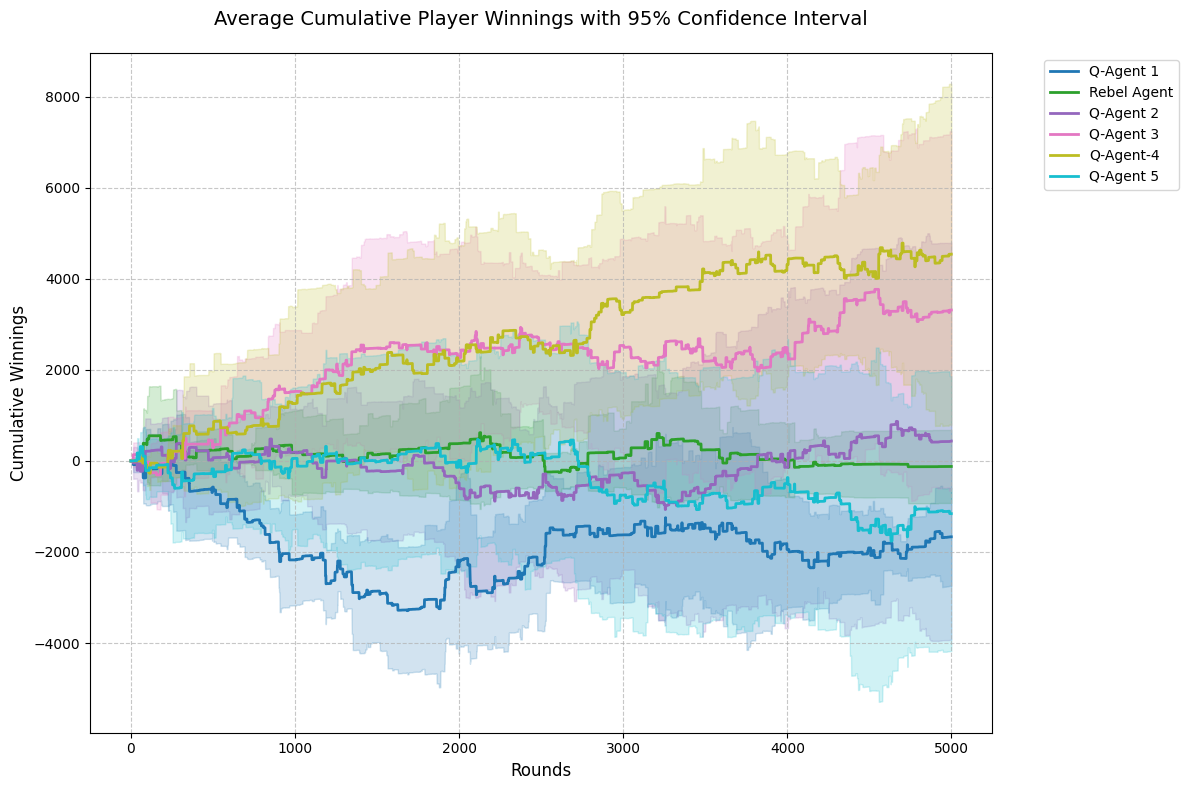

In [182]:
plt1 = plot_cumulative_winnings(total_winnings, ["Q-Agent 1", "Rebel Agent", "Q-Agent 2", "Q-Agent 3", "Q-Agent-4", "Q-Agent 5"], n_iterations)

## Rebel vs ineffective agents

In [183]:
active_players = 6
agents = [REBELAgent(num_players=6), RandomAgent(), FoldAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

In [184]:
n_trials = 5
n_iterations = 5000
total_winnings = []
for t in range(n_trials):
    table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
    table.seed(t)
    player_winnings = learningLoop(table, agents, active_players, n_iterations)
    print(f"Trial {t+1} completed")
    total_winnings.append(player_winnings)


Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000


KeyboardInterrupt: 

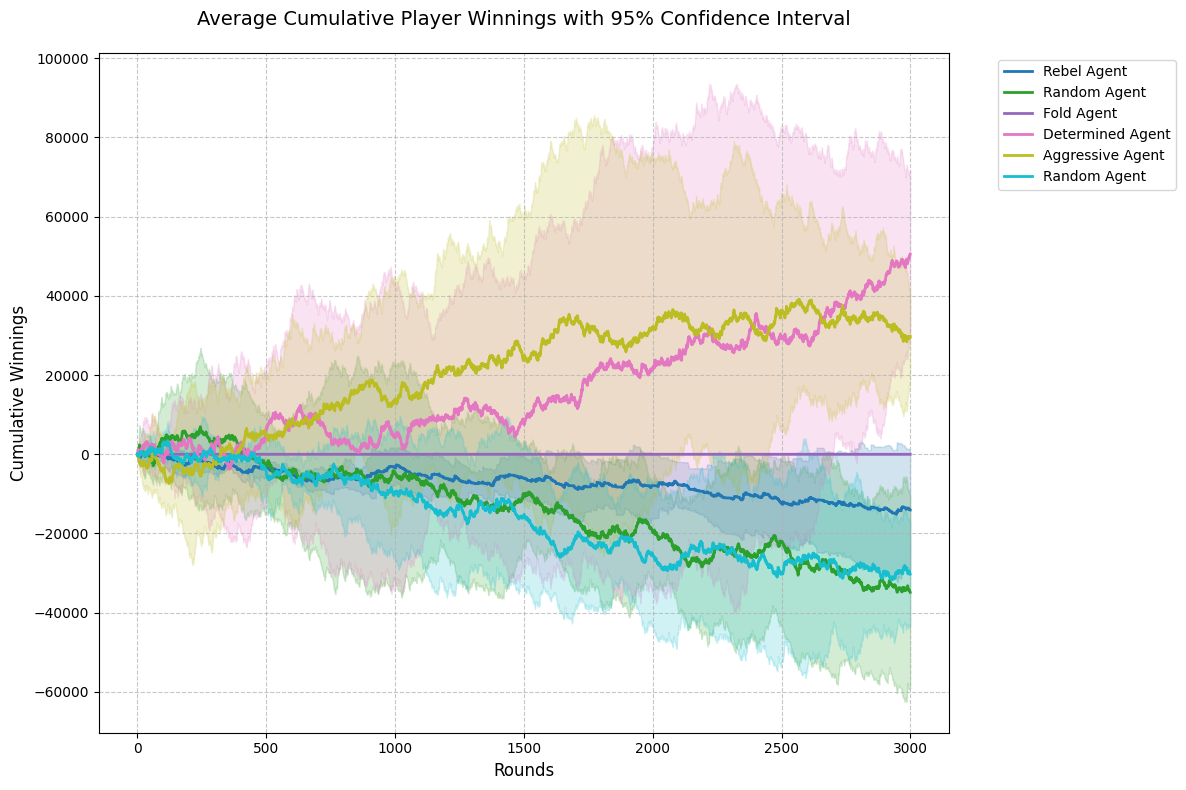

In [ ]:
players = ["Rebel Agent", "Random Agent", "Fold Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

plt2 = plot_cumulative_winnings(total_winnings, players, n_iterations)

## 1 Rebel 3 Q-Learning 2 Random

In [ ]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(num_players=6), RandomAgent(), QLearningAgent(), RandomAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 499
high_stack_bbs = 500
hand_history_location = 'Hands/'
invalid_action_penalty = 10

In [ ]:
n_trials = 1
n_iterations = 3000
total_winnings = []
for t in range(n_trials):
    table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
    table.seed(t)
    player_winnings = learningLoop(table, agents, active_players, n_iterations)
    print(f"Trial {t+1} completed")
    total_winnings.append(player_winnings)

Iteration: 500
Iteration: 1000


KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


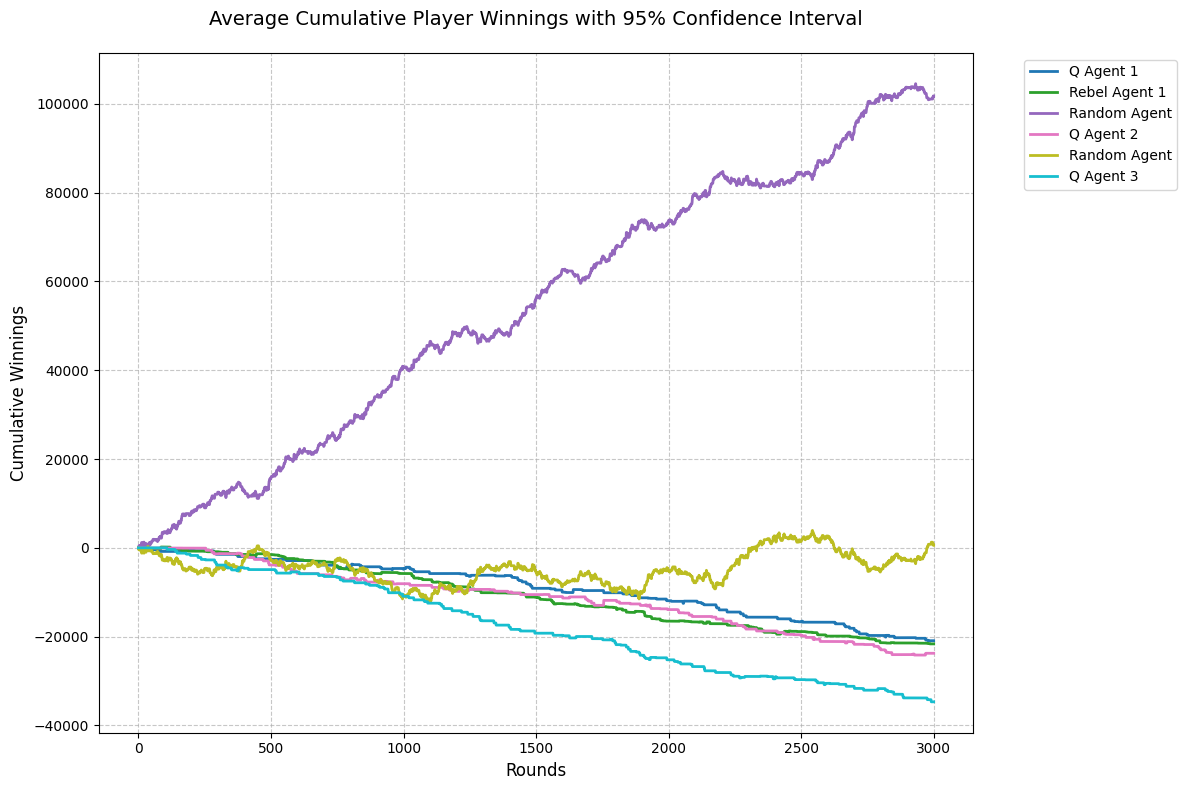

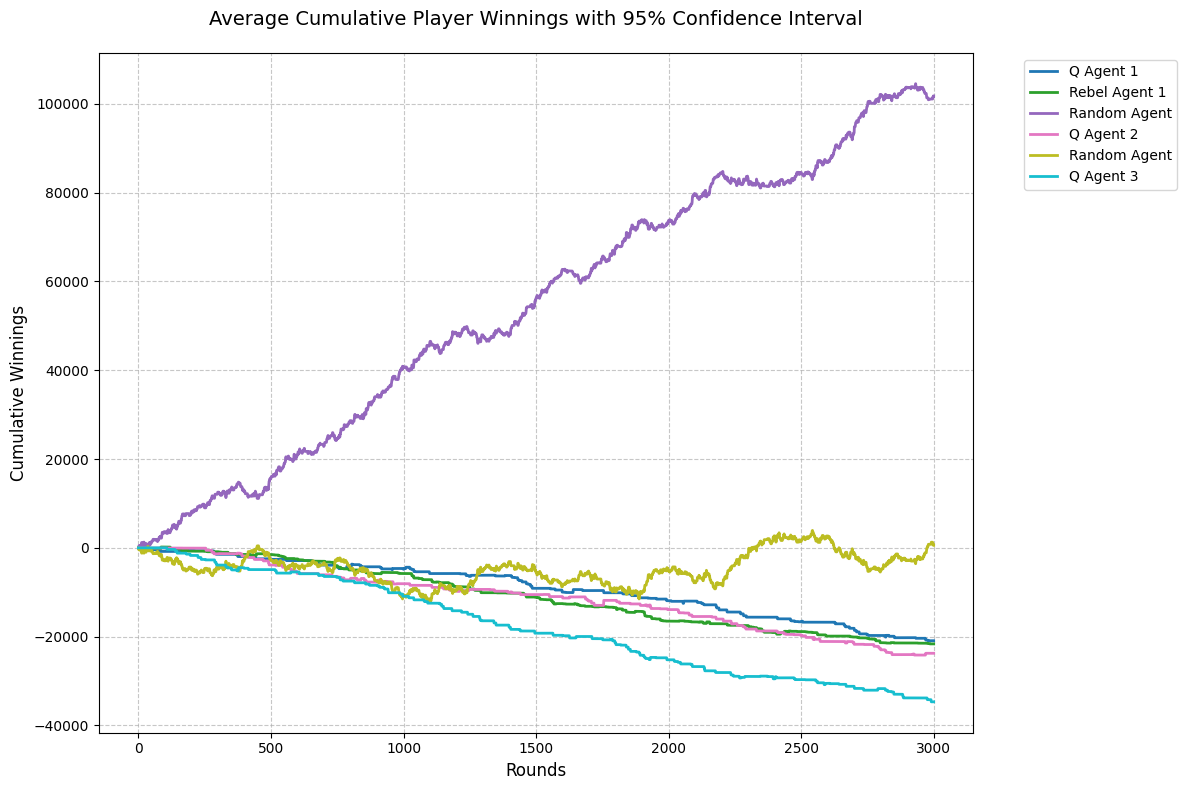

In [ ]:
players = ["Q Agent 1", "Rebel Agent 1", "Random Agent", "Q Agent 2", "Random Agent", "Q Agent 3"]

plt3 = plot_cumulative_winnings(total_winnings, players, n_iterations)

## 3 Rebel vs 3 Q-Learning

In [ ]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(active_players), REBELAgent(active_players), QLearningAgent(), REBELAgent(active_players), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 499
high_stack_bbs = 500
hand_history_location = 'Hands/'
invalid_action_penalty = 10

In [ ]:
n_trials = 10
n_iterations = 5000
total_winnings = []
for t in range(n_trials):
    table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
    table.seed(t)
    player_winnings = learningLoop(table, agents, active_players, n_iterations)
    print(f"Trial {t+1} completed")
    total_winnings.append(player_winnings)

In [ ]:
players = ["Q Agent 1", "Rebel Agent 1", "Rebel Agent 2", "Q Agent 2", "Rebel Agent 3", "Q Agent 3"]

plt = plot_cumulative_winnings(total_winnings, players, n_iterations)